### *Microlensing Statistics (Finite Source - Point lens)*

Microlensing statistics but with the inclusion of the finite source effect for the M31 observations by Niikura et. al **1701.02151**. 

Includes a very fast approximation of the magnification wirth the finite source size effect by José Pereira. 


# **Exact expression**

In [1]:
'''
Microlensing magnification by a pointlike source.
Ref: WITT, M., MAO, S., Can lensed stars be regarded as pointlike for microlensing by MACHOS?, 1996.
'''
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import mpmath as mpmath
from scipy import integrate
import sympy as sp
import astropy.constants as act
import astropy.units as aut
import sympy as sp
from astropy import units as u
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from scipy.special import j0

kpc = act.kpc.to_value()
MSun = act.M_sun.to_value()
G_num = act.G.to_value()
c = act.c.to_value()
RSun=act.R_sun.to_value()
d_s = sp.Symbol('d_s')
d = sp.Symbol('d')
d_s = 770*kpc

"""
Cálculo numérico da magnificação.
Equação (5) do paper.
"""

def magnification_finitesource_N(r, u):
  """
  Funcao que calcula a magnificacao de uma fonte finita atraves da integracao numerica. Equação (5) do artigo de referencia.

  Args:
    r: raio da fonte (em unidades do raio de einstein)
    u: posição da fonte com relação ao centro da lente (em unidades do raio de einstein)

  """

  def Nmag_1(r, u):

    def integrando_1(phi, r):

        f1 = 1 + np.sqrt(np.abs(1 + 4/(u**2 + r**2 + 2*u*r*np.cos(phi))))
        y1 = r*np.sin(phi)*f1/2

        #derivada d(x1)/dphi. expressão calculada no mathematica:
        denominador_termo1 = np.sqrt(1 + 4/(r*r+u*u+2*r*u*np.cos(phi))) * (r*r+u*u+2*r*u*np.cos(phi))**2
        termo1 = 2*r*u*np.sin(phi)*(u+r*np.cos(phi))/denominador_termo1
        termo2 = r*np.sin(phi)*(1 + np.sqrt(1 + 4/(r*r+u*u+2*r*u*np.cos(phi))))/2

        D_x1 = termo1 - termo2

        return y1*D_x1

    area_imagem1 = integrate.quad(integrando_1, 0, 2*np.pi, args=(r))
    area_fonte = np.pi*r**2

    return area_imagem1[0] / area_fonte

  def Nmag_2(r, u):

    def integrando_2(phi, r):

        f2 = 1 - np.sqrt(np.abs(1 + 4/(u**2 + r**2 + 2*u*r*np.cos(phi))))
        y2 = r*np.sin(phi)*f2/2

        #derivada d(x2)/dphi. expressão calculada no mathematica:
        denominador_termo1 = np.sqrt(1 + 4/(r*r+u*u+2*r*u*np.cos(phi))) * (r*r+u*u+2*r*u*np.cos(phi))**2
        termo1 = 2*r*u*np.sin(phi)*(u+r*np.cos(phi))/denominador_termo1
        termo2 = r*np.sin(phi)*(1 - np.sqrt(1 + 4/(r*r+u*u+2*r*u*np.cos(phi))))/2

        D_x2 = - termo1 - termo2

        return y2*D_x2

    area_imagem2 = integrate.quad(integrando_2, 0, 2*np.pi, args=(r))
    area_fonte = np.pi*r**2

    return area_imagem2[0] / area_fonte

  if np.abs(u) <= r:
   return np.abs(Nmag_1(r, u)) - np.abs(Nmag_2(r, u))

  else:
    return np.abs(Nmag_1(r, u)) + np.abs(Nmag_2(r, u))




"""
Cálculo analítico da magnificação.
Equações (9), (11) e (14) do paper.
"""

def magnification_finitesource_A(r, u):

    """
    Funcao que calcula a magnificacao de uma fonte finita analiticamente. Equacoes (9), (11) e (14) do artigo de referencia.

    Args:
      r: raio da fonte (em unidades do raio de einstein)
      u: posição da fonte com relação ao centro da lente (em unidades do raio de einstein)

    """

    #magnificação quando u > r (equacao 9)
    def mag_ur_dif (r, u):

        #argumentos das funcoes elipticas
        n = (4 * u * r)/(u + r)**2
        k = ((4 * n)/(4 + (u - r)**2))

        a = float(mpmath.ellipe(k).real) * ((u + r) / (2 * r**2)) * np.sqrt(4 + (u - r)**2)
        b = float(mpmath.ellipk(k).real) * ((u - r) / (r**2)) * ((4 + (u**2 - r**2)/2) / np.sqrt(4 + (u - r)**2))
        c = float(mpmath.ellippi(n, k))*((2 * (u - r)**2) / (r**2 * (u + r)))*((1 + r**2)/np.sqrt(4 + (u - r)**2))

        mag1 = (1/(2*np.pi))*(+np.pi + a - b + c)
        mag2 = (1/(2*np.pi))*(-np.pi + a - b + c)

        return np.abs(mag1) + np.abs(mag2)

    #magnificaçao quando u = r (equacao 11)
    def mag_ur_iguais (r):

        termo1 = 2/r
        termo2 = (1+r**2)/r**2
        termo3 = np.pi/2 + np.arcsin((r**2 - 1)/(r**2 + 1))

        return (termo1 + termo2*termo3)/np.pi

    #magnificação máxima, lente e fonte perfeitamente alinhadas, u = 0 (equacao 14)
    def mag_u0 (r):

        return np.sqrt(4 + r**2)/r

    if np.abs(u) != r:
        return mag_ur_dif(r, u)


    elif np.abs(u) == 0:
        return mag_u0(r)

    else:
        return mag_ur_iguais(r)



"""
Cálculo da magnificação de uma fonte pontual.
Equação (13) do paper.
"""

def magnification_pontualsource(u):
  """
  Funcao que calcula a magnificacao de uma fonte infinitesimal. Equacao (13) do artigo de referencia.

  Args:
    u: posicao da fonte com relação ao centro da lente (em unidades do raio de einstein)

  """
  u=np.abs(u)
  return (u**2 + 2)/(u*np.sqrt(u**2 + 4))

'''
No caso destes funções, r é o RAIO ADIMENSIONAL DA FONTE. No código que segue, a expressão source_size que leva como
variável 'r', este na verdade é o raio real da fonte, e este resultado é equivalente ao 'r' das expressões acima.
'''

# %%

"\nNo caso destes funções, r é o RAIO ADIMENSIONAL DA FONTE. No código que segue, a expressão source_size que leva como\nvariável 'r', este na verdade é o raio real da fonte, e este resultado é equivalente ao 'r' das expressões acima.\n"

# **Approximation**

In [2]:
def mag_aprox(r, u):
    r2 = r**2
    r4 = r**4
    sqrt_4_r2 = np.sqrt(4 + r2)
    epsilon_r = 0.15472987948000147 * r

    def mag_u_maiorq_r(u):
        u2 = u**2
        u3 = u**3
        u4 = u**4
        u5 = u**5
        u6 = u**6
        sqrt_4_u2 = np.sqrt(4 + u2)
        c0 = (2 + u2) / (u * sqrt_4_u2)
        c2 = (8 * (1 + u2)) / (u3 * (4 + u2)**(5/2))
        c4 = (48 * (12 + 14*u2 + 6*u4 + 3*u6)) / (u5 * (4 + u2)**(9/2))
        return c0 + c2 * r2 / 2 + c4 * r4 / 24

    def derivada_u_maior(u):
        u2 = u**2
        u3 = u**3
        u4 = u**4
        u5 = u**5
        u6 = u**6
        sqrt_4_u2 = np.sqrt(4 + u2)
        sqrt_4_u2_3_2 = (4 + u2)**(3/2)
        sqrt_4_u2_5_2 = (4 + u2)**(5/2)
        sqrt_4_u2_7_2 = (4 + u2)**(7/2)
        sqrt_4_u2_9_2 = (4 + u2)**(9/2)
        sqrt_4_u2_11_2 = (4 + u2)**(11/2)

        term1 = -(20 * r2 * (1 + u2)) / (u2 * sqrt_4_u2_7_2)
        term2 = (8 * r2) / (u2 * sqrt_4_u2_5_2)
        term3 = -(12 * r2 * (1 + u2)) / (u4 * sqrt_4_u2_5_2)
        term4 = -(2 + u2) / sqrt_4_u2_3_2
        term5 = 2 / sqrt_4_u2
        term6 = -(2 + u2) / (u2 * sqrt_4_u2)
        term7 = (2 * r4 * (28 * u + 24 * u**3 + 18 * u5)) / (u5 * sqrt_4_u2_9_2)
        term8 = -(18 * r4 * (12 + 14 * u2 + 6 * u4 + 3 * u5)) / (u4 * sqrt_4_u2_11_2)
        term9 = -(10 * r4 * (12 + 14 * u2 + 6 * u4 + 3 * u5)) / (u6 * sqrt_4_u2_9_2)
        return term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8 + term9

    def mag_u_menorq_r(u):
        u2 = u**2
        u4 = u**4
        a0 = sqrt_4_r2 / r
        a2 = -8 / (r**3 * (4 + r2)**(3/2))
        a4 = (-144 * (2 + 2*r2 + r4)) / (r**5 * (4 + r2)**(7/2))
        return a0 + a2 * u2 / 2 + a4 * u4 / 24
    def derivada_u_menor(u):
        a2 = -8 / (r**3 * (4 + r2)**(3/2))
        a4 = (-144 * (2 + 2*r2 + r4)) / (r**5 * (4 + r2)**(7/2))
        return a2 * u + a4 * u**3 / 6

    def mag_interp2(u):
        derivada_maior = derivada_u_maior(r + epsilon_r)
        mag_maior = mag_u_maiorq_r(r + epsilon_r)
        h = 2 * epsilon_r

        mag_menor = mag_u_menorq_r(r - epsilon_r)
        derivada_menor = derivada_u_menor(r - epsilon_r)

        a = (-2 * mag_maior + 2 * mag_menor + derivada_maior * h + derivada_menor * h) / h**3
        b = (-3 * mag_maior + 3 * mag_menor + 2 * derivada_maior * h + derivada_menor * h) / h**2

        x1 = r + epsilon_r
        return a * (u - x1)**3 + b * (u - x1)**2 + derivada_maior * (u - x1) + mag_maior

    if not np.isscalar(u):
        u = np.asarray(u)

        abs_u = np.abs(u)
        abs_u_r = np.abs(u - r)

        condition1 = np.logical_and(abs_u > r, abs_u_r > epsilon_r)
        condition2 = np.logical_and(abs_u < r, abs_u_r > epsilon_r)
        condition3 = abs_u_r <= epsilon_r

        result = np.where(condition1,
                          np.abs(mag_u_maiorq_r(u)),
                          np.where(condition2,
                                   np.abs(mag_u_menorq_r(u)),
                                   mag_interp2(u)))

        result[abs_u == 0] = sqrt_4_r2 / r

        return result

    else:
        abs_u = np.abs(u)
        abs_u_r = np.abs(u - r)

        if abs_u > r and abs_u_r > epsilon_r:
            return np.abs(mag_u_maiorq_r(u))

        if abs_u < r and abs_u_r > epsilon_r:
            return np.abs(mag_u_menorq_r(u))

        if abs_u_r <= epsilon_r:
            return mag_interp2(u)

        if abs_u == 0:
            return sqrt_4_r2 / r

# **Finite Source roots (using approximation)**

In [3]:
from scipy.optimize import fsolve

'''
Returns u_th such that mag_aprox(r, u) - 1.34 = 0,
'''

def dif_mag_root(u, r):
    
    return mag_aprox(r, u) - 1.34

def u_threshold(r, u0):

    args=(r)
    
    u_th = fsolve(dif_mag_root, u0, args=args, fprime=None, xtol=1.49012e-08)
    return np.abs(u_th)


def source_size(R, d, M_PBH):
    ''' 
    Dimensionless source size, where R is the physical source size 
    '''
    theta_E = np.sqrt((4*G_num*M_PBH*(d_s-d))/(c**2 * d_s * d))
    
    return R/(d_s*theta_E)

In [4]:
RSource = np.vectorize(source_size)
u_T = np.vectorize(u_threshold)
r_range = np.linspace(0.001, 3, 500)

# **Piece-wise function to find u_T in terms of r**

In [5]:
from scipy.interpolate import interp1d

u_T_interp = interp1d(r_range, u_T(r=r_range, u0=1), kind='linear')

@np.vectorize
def u_T_pc(r):

    if r<0.1:

        return 1

    elif r>np.sqrt(5):

        return 0

    else:

        return u_T_interp(r)

list_u_T = []

for i in r_range:
    value = u_T_pc(i)
    list_u_T.append(value)

In [6]:
def u_Th(d, R, m_pbh):

    '''
    Rewritting in terms of physical source size, distance from lens and PBH mass
    '''

    r = (R/d_s)/(R_E(d, m_pbh)/d)

    if r<0.1:

        return 1

    elif r>np.sqrt(5):

        return 0

    else:

        return float(u_T_interp(r))

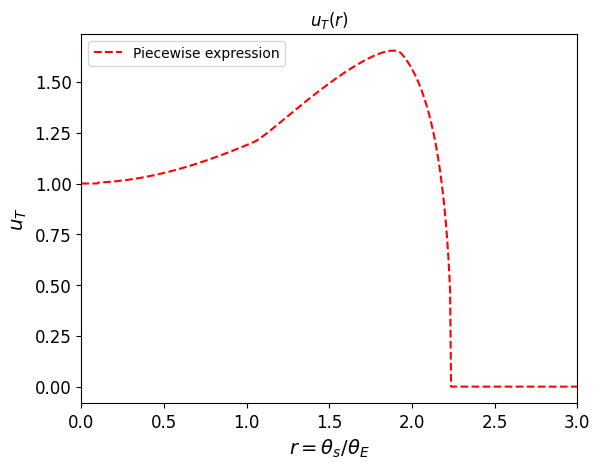

In [7]:
plt.plot(r_range, list_u_T, '--', color='red', label='Piecewise expression')

plt.title(r'$u_{T} (r)$')
plt.xlabel(r'$r=\theta_{s}/\theta_{E}$', fontsize=14)
plt.ylabel(r'$u_T$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(0, 3)

plt.legend(fontsize=10)
plt.show()

# **HSC Event Rate w/ Finite Source Size Effects**

In [8]:
from scipy.integrate import dblquad, quad

d_s = sp.Symbol('d_s')
d = sp.Symbol('d')
m_pbh = sp.Symbol('m_pbh')
R = sp.Symbol('R')

rho_c_MW = 4.88e6 * MSun/kpc**3
rho_c_M31 = 4.96e6 * MSun/kpc**3
r_s_MW = 21.5 * kpc
r_s_M31 = 25 * kpc
r_sun = 8.5*kpc
l_M31 = 121.2 # degree
b_M31 = -21.6 # degree
d_s = 770 * kpc
hour = 3600 # seconds

In [9]:
### Einstein radius and source size, and u_T(d, R, m_pbh)

'''
Now, quantities can depend on the value of u_T, and this will influence on the event rate
'''

def R_E(d, m_pbh):
    arg = ((4*G_num * m_pbh * d * (1 - d/d_s))/(c)**2)
    result = np.sqrt(abs(arg))

    return result

def size(d, R, m_pbh):

    theta_s = R/d_s
    theta_E = (R_E(d, m_pbh)/d)

    return theta_s/theta_E

### Distances

def r_MW(d):

    r_mw = np.sqrt((r_sun)**2 + d**2 - 2*r_sun*d*np.cos(np.radians(l_M31))*np.cos(np.radians(b_M31)))

    return r_mw 

def r_M31(d):

    r_m31 = (d_s - d)

    return r_m31 

### Dark matter densities

def density_DM_MW(d):

    term1 =  rho_c_MW
    term2 = (r_MW(d) / r_s_MW)
    term3 = (1 + r_MW(d) / r_s_MW)**2
    
    return (term1 /(term2 * term3))

def density_DM_M31(d):
    
    term4 = rho_c_M31               
    term5 = (r_M31(d) / r_s_M31)
    term6 = (1 + r_M31(d) / r_s_M31)**2
    
    return  (term4 / (term5 * term6))

def density_DM(d):
    
    return density_DM_MW(d) + density_DM_M31(d)

### NFW Masses

def M_NFW_MW(d):
  c = (r_MW(d)/r_s_MW)

  func1 = (4 * np.pi * rho_c_MW * (r_s_MW)**3)
  func2 =  (np.log(1 + c) - (c/(1 + c)))

  return func1 * func2

def M_NFW_M31(d):
   c = (r_M31(d)/r_s_M31)

   func1 = (4 * np.pi * rho_c_M31 * (r_s_M31)**3)
   func2 =  (np.log(1 + c) - (c/(1 + c)))
   return func1 * func2

### Peculiar velocities

def v_c_MW(d):
  v_c_MW = np.sqrt((G_num * M_NFW_MW(d))/r_MW(d))

  return v_c_MW

def v_c_M31(d):
    v_c_M31 = np.sqrt((G_num * M_NFW_M31(d))/r_M31(d))

    return v_c_M31

### Integrands

def integrand_MW(d, u_min, R, t, m_pbh):

    v_r = ((2 * R_E(d, m_pbh) * np.sqrt(u_Th(d, R, m_pbh)**2 - u_min**2))/(t))
    Q = v_r/v_c_MW(d)

    term1 = ((density_DM_MW(d))/(m_pbh * v_c_MW(d)**2 ))
    term2 = (v_r**4/np.sqrt(u_Th(d, R, m_pbh)**2 - u_min**2))
    term3 = np.exp(-Q**2)

    return  (2*term1*term2*term3)

def integrand_M31(d, u_min, R, t, m_pbh):

    v_r = ((2 * R_E(d, m_pbh) * np.sqrt(u_Th(d, R, m_pbh)**2 - u_min**2))/(t))
    Q = v_r/v_c_M31(d)

    term1 = ((density_DM_M31(d))/(m_pbh * v_c_M31(d)**2 ))
    term2 = (v_r**4/np.sqrt(u_Th(d, R, m_pbh)**2 - u_min**2))
    term3 = np.exp(-Q**2)

    return  ((2*term1*term2*term3))

### Event rate integrals

def event_rate_MW(t, R, m_pbh):

    integral = dblquad(integrand_MW, 0, u_Th, 0, d_s, args=(t, R, m_pbh,), epsabs=1.49e-03, epsrel = 5e-29)[0]

    return integral

def event_rate_M31(t, R, m_pbh):

    integral = dblquad(integrand_M31, 0, u_Th, 0, d_s, args=(t, R, m_pbh,), epsabs=1.49e-03, epsrel = 5e-29)[0]

    return integral


@np.vectorize
def event_rate_HSC(t, R, m_pbh):

    return event_rate_M31(t, R, m_pbh) + event_rate_MW(t, R, m_pbh)

In [10]:
import numpy as np
from scipy.integrate import quad

'''
Inner integrals over u_min for a given u_T_bound that's given by u_Th. Fixed R and variable distance and PBH mass
'''

@np.vectorize
def inner_integral_MW(d, R, t, m_pbh):
    def integrand_MW(u_min, d, R, t, m_pbh):
        try:
            v_r = ((2 * R_E(d, m_pbh) * np.sqrt(u_Th(d, R, m_pbh)**2 - u_min**2))/(t))
            Q = v_r/v_c_MW(d)

            term1 = ((density_DM_MW(d))/(m_pbh * v_c_MW(d)**2 ))
            term2 = (v_r**4/np.sqrt(u_Th(d, R, m_pbh)**2 - u_min**2))
            term3 = np.exp(-Q**2)

            result =  (2*term1*term2*term3)
            

            
            return result
        except:
            return np.nan

    u_T_bound = u_Th(d, R, m_pbh)

    integral = quad(integrand_MW, 0, u_T_bound, args=(d, R, t, m_pbh))[0]

    if u_T_bound == 0:
        return 0

    else:
    
        return integral

@np.vectorize
def inner_integral_M31(d, R, t, m_pbh):
    def integrand_M31(u_min, d, R, t, m_pbh):
        try:
            v_r = ((2 * R_E(d, m_pbh) * np.sqrt(u_Th(d, R, m_pbh)**2 - u_min**2))/(t))
            Q = v_r/v_c_M31(d)

            term1 = ((density_DM_M31(d))/(m_pbh * v_c_M31(d)**2 ))
            term2 = (v_r**4/np.sqrt(u_Th(d, R, m_pbh)**2 - u_min**2))
            term3 = np.exp(-Q**2)

            result =  (2*term1*term2*term3)

            return result
        except:
            return np.nan

    u_T_bound = u_Th(d, R, m_pbh)

    integral = quad(integrand_M31, 0, u_T_bound, args=(d, R, t, m_pbh))[0]

    if u_T_bound == 0:
        return 0

    else:
    
        return integral

In [11]:
d_geom = np.geomspace(1e-5, 770, 250)*kpc

In [15]:
''''
Outer integrals using Simpson integration due to complications with masses below 10^{-12} MSun with other methods
'''

from multiprocessing import Pool
from functools import partial
from scipy.integrate import simps



def outer_mw(t, R, m_pbh):

    integral = simps(inner_integral_MW(d=d_geom, R=RSun, t=t, m_pbh=m_pbh), d_geom)

    return integral


def outer_m31(t, R, m_pbh):

    integral = simps(inner_integral_M31(d=d_geom, R=RSun, t=t, m_pbh=m_pbh), d_geom)

    return integral

def parallel_outer_mw(t, R, m_pbh, process=8):

    pool = Pool(process)
    ans = np.array(
        pool.map(
            partial(
                outer_mw,
                R=R,
                m_pbh=m_pbh,
            ),
            t,
        )
    )

    return ans

def parallel_outer_m31(t, R, m_pbh, process=8):

    pool = Pool(process)
    ans = np.array(
        pool.map(
            partial(
                outer_m31,
                R=R,
                m_pbh=m_pbh,
            ),
            t,
        )
    )

    return ans

def hsc_events(t, R, m_pbh):

    event_mw = outer_mw(t, R, m_pbh)
    event_m31 = outer_m31(t, R, m_pbh)

    return event_mw + event_m31

def parallel_hsc_events(t, R, m_pbh):

    event_mw = parallel_outer_mw(t, R, m_pbh, process=8)
    event_m31 = parallel_outer_m31(t, R, m_pbh, process=8)

    return event_mw + event_m31

In [16]:
t_obs = np.geomspace(0.01, 10, 100)*hour

simps_7 = hour**2 * parallel_hsc_events(t=t_obs, R=RSun, m_pbh=1e-7*MSun)
simps_8 = hour**2 * parallel_hsc_events(t=t_obs, R=RSun, m_pbh=1e-8*MSun)
simps_9 = hour**2 * parallel_hsc_events(t=t_obs, R=RSun, m_pbh=1e-9*MSun)
simps_10 = hour**2 * parallel_hsc_events(t=t_obs, R=RSun, m_pbh=1e-10*MSun)
simps_11 = hour**2 * parallel_hsc_events(t=t_obs, R=RSun, m_pbh=1e-11*MSun)
simps_12 = hour**2 * parallel_hsc_events(t=t_obs, R=RSun, m_pbh=1e-12*MSun)

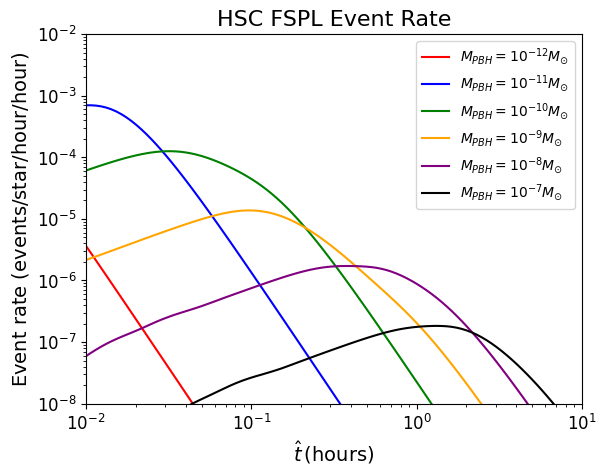

In [17]:
plt.Figure(figsize=(8, 6))

plt.title(r'HSC FSPL Event Rate', fontsize=16)

plt.loglog(t_obs/hour, simps_12, color='red', label=r'$M_{PBH} = 10^{-12} M_{\odot}$')
plt.loglog(t_obs/hour, simps_11, color='blue', label=r'$M_{PBH} = 10^{-11} M_{\odot}$')
plt.loglog(t_obs/hour, simps_10, color='green', label=r'$M_{PBH} = 10^{-10} M_{\odot}$')
plt.loglog(t_obs/hour, simps_9, color='orange', label=r'$M_{PBH} = 10^{-9} M_{\odot}$')
plt.loglog(t_obs/hour, simps_8, color='purple', label=r'$M_{PBH} = 10^{-8} M_{\odot}$')
plt.loglog(t_obs/hour, simps_7, color='black', label=r'$M_{PBH} = 10^{-7} M_{\odot}$')

plt.xlabel(r'$\hat{t}\,(\mathrm{hours})$', fontsize=14)
plt.ylabel(r'Event rate ($\mathrm{events/star/hour/hour}$)', fontsize=14)

plt.xlim(0.01, 10)
plt.ylim(1e-8, 1e-2)

plt.legend(fontsize=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

# **HSC FSPL Bounds on DM**

In [18]:
''''
Extracted data from Niikura et. al 1701.02151 for efficiency calculation

OBS: Despite the time axis being in t_FWHM, we are assuming t_FWHM ~ t_hat  for simplicity and conversion complications.
'''

time_hsc = np.array([0.01674482, 0.03272845, 0.04986102, 0.07030965, 0.12940179,
       0.32728445, 0.49861024, 0.99144507, 1.48471054, 1.97140621,
       2.97769764, 3.95380208, 4.98610241, 5.97199455, 6.85205587])*hour

efficiency_hsc = np.array([0.02820513, 0.05641026, 0.17435897, 0.47948718, 0.58205128,
       0.59230769, 0.62051282, 0.61538462, 0.61794872, 0.54615385,
       0.51282051, 0.34358974, 0.08974359, 0.02820513, 0.01538462])

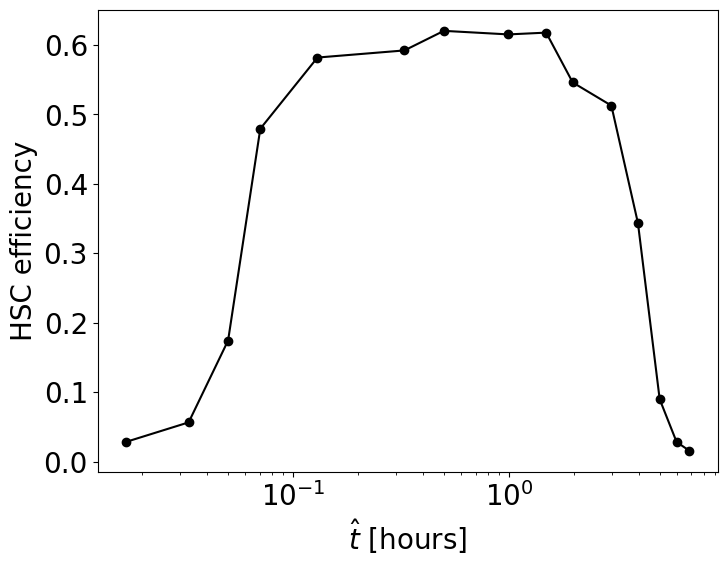

In [19]:
plt.figure(figsize = (8, 6))

plt.semilogx(time_hsc/hour, efficiency_hsc, '-o', color='black')
plt.xlabel(r'$\hat{t}$ [hours]', fontsize=20)
plt.ylabel('HSC efficiency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.grid(True)
plt.show()

In [20]:
'''
Efficiency interpolation
'''

from scipy.interpolate import interp1d

time_interp = np.geomspace(time_hsc[0], time_hsc[-1], 500) # Already in seconds

eff_interp = interp1d(time_hsc, efficiency_hsc, kind='linear')(time_interp)

In [21]:
'''
Interpolation function dependent on t, and efficiency interpolation
'''
@np.vectorize
def hsc_eff(t):
  if t < time_hsc.min():
    interp = 0

  elif t > time_hsc.max():
    interp = 0
  
  else:
    interp = interp1d(time_hsc, efficiency_hsc, kind='linear')(t)
  # print(f'Time: {t/hour}, Efficiency: {interp}')
  return interp

interpolated_eff = hsc_eff(time_interp)

In [26]:
'''
Expected number of events integral
'''

def expected_events_integrand(t, R, m_pbh):

    term1 = hsc_eff(t)
    term2 = hsc_events(t, R, m_pbh)

    return term1 * term2


def expected_events(R, m_pbh):

    E = 2.2e12 # stars-seconds, converted from 7*8.7e4 stars-hours
    integral = quad(expected_events_integrand, time_hsc.min(), time_hsc.max(), args=(R, m_pbh))[0]


    return E * integral

In [27]:
'''
Parallelizing expected events
'''

def parallel_expected_events(R, m_pbh):
    with Pool(processes=8) as pool:
        func = partial(expected_events, R)
        ans = np.array(pool.map(func, m_pbh))
    return ans

In [28]:
M_range = np.geomspace(1e-15, 1e-3, 100)*MSun

In [29]:
N_exp = parallel_expected_events(R=RSun, m_pbh=M_range)

In [30]:
f_DM = 4.74/(N_exp)

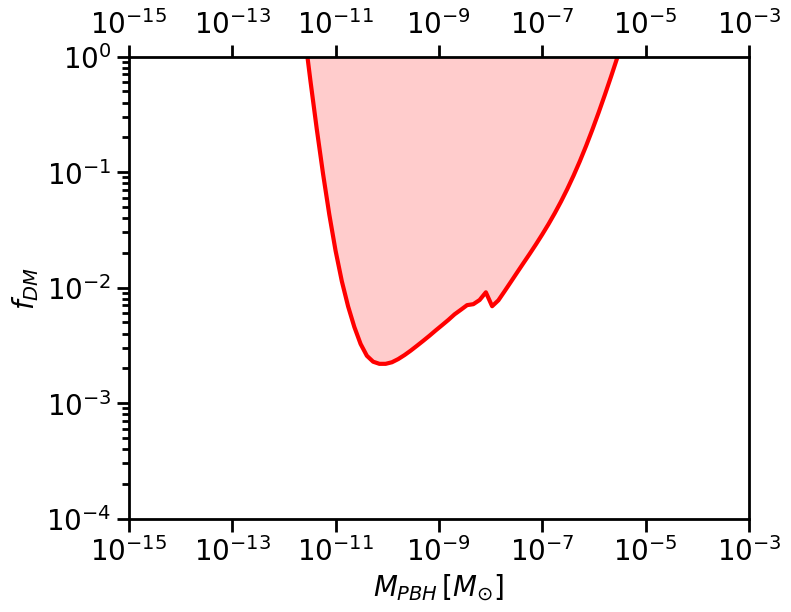

In [31]:
plt.figure(figsize=(8,6))
ax=plt.axes()

plt.loglog(M_range/MSun, f_DM, linewidth=3, color='red')
plt.ylim(1e-4,1)
plt.xlim(1e-15,1e-3)

plt.xlabel(r'$M_{PBH}\,[M_{\odot}]$', fontsize=20)
plt.ylabel(r'$f_{DM}$', fontsize=20)
plt.fill_between(M_range/MSun, f_DM, 1, facecolor='red', alpha=0.2)
plt.tick_params(top=True, labeltop=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=9)
ax.tick_params(which='minor', length=5, color='black')

# **Statistics with Top Hat efficienct and ODIs**

In [32]:
minute = 60

def hsc_top_hat(t):

    if t <= 3 * minute:
        return 0
    elif t <= 4 * hour:
        return 0.8
    else:
        return 0


def hsc_odi_skipper(t):

    if t <= 2:
        return 0

    elif t<= 4*hour:
        return 0.8

    else:
        return 0

def hsc_odi_skipper10(t):
    if t <= 2:
        return 0

    elif t<= 40*hour:
        return 0.8

    else:
        return 0

**Top Hat**

In [35]:
'''
Expected number of events integral for Analytical HSC Top Hat
'''

def expected_events_integrand_TH(t, R, m_pbh):

    term1 = hsc_top_hat(t)
    term2 = hsc_events(t, R, m_pbh)

    return term1 * term2


def expected_events_TH(R, m_pbh):

    E = 2.2e12 # stars-seconds, converted from 7*8.7e4 stars-hours
    integral = quad(expected_events_integrand_TH, 3*minute, 4*hour, args=(R, m_pbh))[0]

    return E * integral

def parallel_expected_events_TH(R, m_pbh):
    with Pool(processes=8) as pool:
        func = partial(expected_events_TH, R)
        ans = np.array(pool.map(func, m_pbh))
    return ans

In [36]:
N_exp_TH = parallel_expected_events_TH(R=RSun, m_pbh=M_range)

In [37]:
f_DM_TH = 4.74/N_exp_TH

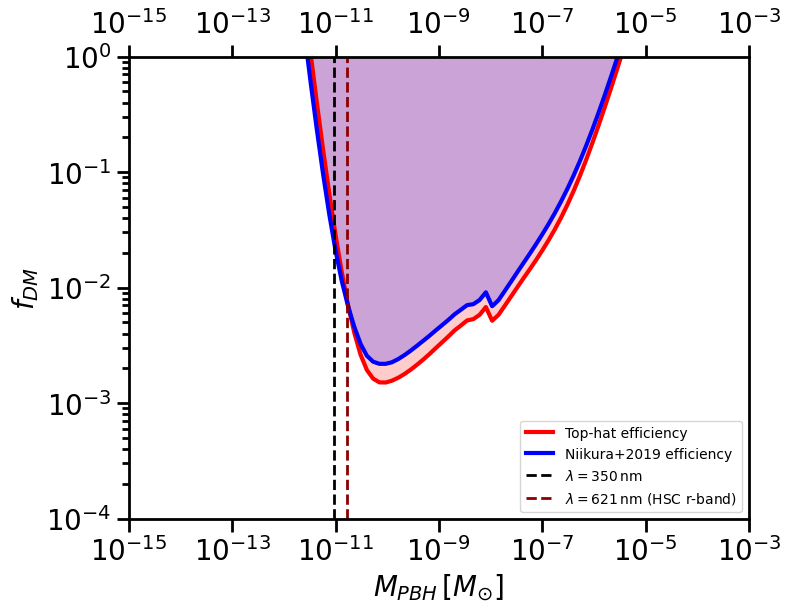

In [38]:
plt.figure(figsize=(8,6))
ax=plt.axes()

plt.loglog(M_range/MSun, f_DM_TH, linewidth=3, color='red', label=r'Top-hat efficiency')
plt.loglog(M_range/MSun, f_DM, linewidth=3, color='blue', label='Niikura+2019 efficiency')
plt.ylim(1e-4,1)
plt.xlim(1e-15,1e-3)

plt.xlabel(r'$M_{PBH}\,[M_{\odot}]$', fontsize=20)
plt.ylabel(r'$f_{DM}$', fontsize=20)
plt.fill_between(M_range/MSun, f_DM_TH, 1, facecolor='red', alpha=0.2)
plt.fill_between(M_range/MSun, f_DM, 1, facecolor='blue', alpha=0.2)
plt.tick_params(top=True, labeltop=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.vlines(x=9.431004596082242e-12, ymin=1e-4, ymax=1, color='black', linestyle='--', linewidth=2, label=r"$\lambda = 350\,\mathrm{nm}$")
plt.vlines(x=1.6733296726191634e-11, ymin=1e-4, ymax=1, color='darkred', linestyle='--', linewidth=2, label=r"$\lambda = 621\,\mathrm{nm}$ (HSC r-band)")

plt.legend(fontsize=10, loc='lower right')

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=9)
ax.tick_params(which='minor', length=5, color='black')

**ODI Skipper CCD**

In [39]:
'''
Expected number of events integral for ODI-Skipper CCD HSC
'''

def expected_events_integrand_ODI(t, R, m_pbh):

    term1 = hsc_odi_skipper(t)
    term2 = hsc_events(t, R, m_pbh)

    return term1 * term2


def expected_events_ODI(R, m_pbh):

    E = 2.2e12 # stars-seconds, converted from 7*8.7e4 stars-hours
    integral = quad(expected_events_integrand_ODI, 2, 4*hour, args=(R, m_pbh))[0]

    return E * integral

def parallel_expected_events_ODI(R, m_pbh):
    with Pool(processes=8) as pool:
        func = partial(expected_events_ODI, R)
        ans = np.array(pool.map(func, m_pbh))
    return ans

In [40]:
N_exp_ODI = parallel_expected_events_ODI(R=RSun, m_pbh=M_range)

f_DM_ODI = 4.74/N_exp_ODI

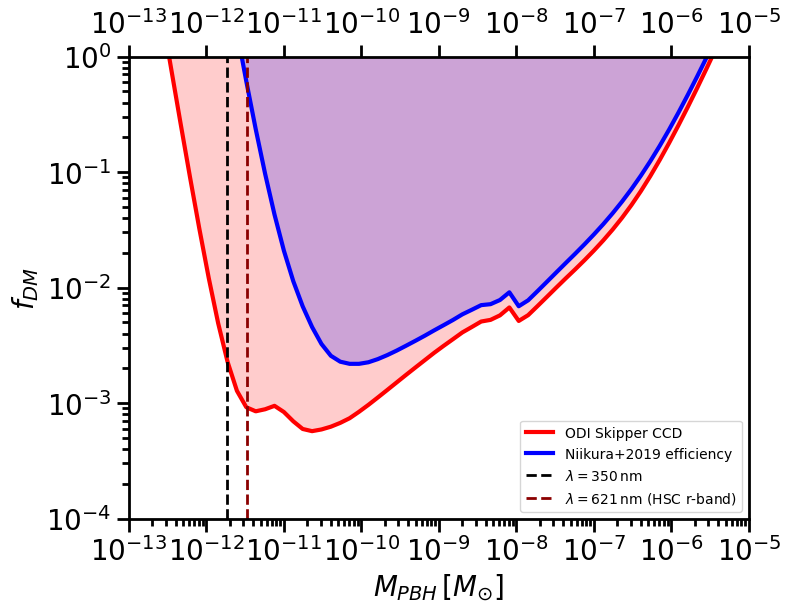

In [41]:
plt.figure(figsize=(8,6))
ax=plt.axes()

plt.loglog(M_range/MSun, f_DM_ODI, linewidth=3, color='red', label=r'ODI Skipper CCD')
plt.loglog(M_range/MSun, f_DM, linewidth=3, color='blue', label='Niikura+2019 efficiency')
plt.ylim(1e-4,1)
plt.xlim(1e-13,1e-5)

plt.xlabel(r'$M_{PBH}\,[M_{\odot}]$', fontsize=20)
plt.ylabel(r'$f_{DM}$', fontsize=20)
plt.fill_between(M_range/MSun, f_DM_ODI, 1, facecolor='red', alpha=0.2)
plt.fill_between(M_range/MSun, f_DM, 1, facecolor='blue', alpha=0.2)
plt.tick_params(top=True, labeltop=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.vlines(x=1.85e-12, ymin=1e-4, ymax=1, color='black', linestyle='--', linewidth=2, label=r"$\lambda = 350\,\mathrm{nm}$")
plt.vlines(x=3.3e-12, ymin=1e-4, ymax=1, color='darkred', linestyle='--', linewidth=2, label=r"$\lambda = 621\,\mathrm{nm}$ (HSC r-band)")

plt.legend(fontsize=10, loc='lower right')

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=9)
ax.tick_params(which='minor', length=5, color='black')